<a href="https://colab.research.google.com/github/Hanbin-git/dacon_new_drug/blob/main/catboost20240707_%EC%8B%9C%EA%B0%81%ED%99%94%EB%A1%9C%20%EB%B3%80%EC%88%98%20%ED%99%95%EC%9D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip -o "/content/drive/MyDrive/data.zip" -d "/content/data_1"


Archive:  /content/drive/MyDrive/data.zip
  inflating: /content/data_1/sample_submission.csv  
  inflating: /content/data_1/test.csv  
  inflating: /content/data_1/train.csv  


In [6]:
# ✅ 필수 라이브러리 설치
!pip install rdkit-pypi catboost --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


In [7]:
# ✅ 라이브러리 import
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from tqdm import tqdm
import os

# ✅ 경로 설정 (Colab 기준)
data_dir = "/content/data_1"
train = pd.read_csv(os.path.join(data_dir, "train.csv"))
test = pd.read_csv(os.path.join(data_dir, "test.csv"))
submission = pd.read_csv(os.path.join(data_dir, "sample_submission.csv"))

# ✅ Morgan fingerprint 추출 함수
def smiles_to_morgan_fp(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    else:
        return None

def extract_morgan_df(df):
    fps = []
    for s in tqdm(df["Canonical_Smiles"]):
        fp = smiles_to_morgan_fp(s)
        if fp is not None:
            arr = np.zeros((1,))
            AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
            fps.append(arr)
        else:
            fps.append(np.zeros(2048))  # 실패한 경우 0으로 채움
    return np.array(fps)

# ✅ 피처 생성
X = extract_morgan_df(train)
X_test = extract_morgan_df(test)
y = train["Inhibition"]

# ✅ KFold + CatBoostRegressor
oof_preds = np.zeros(len(train))
test_preds = np.zeros(len(test))
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"🔁 Fold {fold+1}")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.03,
        depth=6,
        random_seed=42,
        verbose=100,
        early_stopping_rounds=50
    )

    model.fit(X_train, y_train, eval_set=(X_val, y_val))
    oof_preds[val_idx] = model.predict(X_val)
    test_preds += model.predict(X_test) / kf.n_splits

# ✅ 성능 출력 (RMSE 직접 계산)
rmse = np.sqrt(mean_squared_error(y, oof_preds))
print(f"\n✅ CV RMSE: {rmse:.4f}")

# ✅ 제출 파일 저장
submission["Inhibition"] = test_preds
submission.to_csv("submission_catboost_morgan.csv", index=False)
print("📁 'submission_catboost_morgan.csv' 저장 완료")


100%|██████████| 100/100 [00:00<00:00, 475.34it/s]


🔁 Fold 1
0:	learn: 26.3568815	test: 26.3353071	best: 26.3353071 (0)	total: 58.6ms	remaining: 58.5s
100:	learn: 24.0560037	test: 25.3033224	best: 25.3033224 (100)	total: 1.12s	remaining: 9.97s
200:	learn: 22.7715252	test: 25.1295331	best: 25.1249860 (188)	total: 2.17s	remaining: 8.64s
300:	learn: 21.3430207	test: 24.9104325	best: 24.9104325 (300)	total: 3.23s	remaining: 7.5s
400:	learn: 19.7674757	test: 24.7047383	best: 24.6935795 (398)	total: 4.28s	remaining: 6.39s
500:	learn: 18.4416193	test: 24.5980269	best: 24.5980269 (500)	total: 5.72s	remaining: 5.69s
600:	learn: 17.4027155	test: 24.5594819	best: 24.5594819 (600)	total: 6.93s	remaining: 4.6s
700:	learn: 16.4392190	test: 24.5143248	best: 24.5058217 (676)	total: 8.45s	remaining: 3.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 24.5032023
bestIteration = 703

Shrink model to first 704 iterations.
🔁 Fold 2
0:	learn: 26.5871295	test: 25.3824182	best: 25.3824182 (0)	total: 11.3ms	remaining: 11.3s
100:	learn: 24.366

In [8]:
# 총 3가지 세트 실험
# ✅ 라이브러리
import pandas as pd
import numpy as np
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import AllChem
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# ✅ 데이터 경로
path = "/content/data_1/"
train_df = pd.read_csv(path + "train.csv")
test_df = pd.read_csv(path + "test.csv")
submission = pd.read_csv(path + "sample_submission.csv")

# ✅ Morgan Fingerprint 추출 함수
def smiles_to_morgan(smiles, radius=3, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(nBits)
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)

def extract_morgan_df(df, radius=3, nBits=2048):
    fps = []
    for smi in tqdm(df['Canonical_Smiles']):
        fps.append(smiles_to_morgan(smi, radius=radius, nBits=nBits))
    return np.array(fps)

# ✅ 피처 생성
X = extract_morgan_df(train_df, radius=3, nBits=2048)
X_test = extract_morgan_df(test_df, radius=3, nBits=2048)
y = train_df["Inhibition"]

# ✅ KFold 학습
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\n🔁 Fold {fold+1}")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = CatBoostRegressor(
        iterations=2000,
        learning_rate=0.02,
        depth=8,
        l2_leaf_reg=3,
        loss_function='RMSE',
        early_stopping_rounds=100,
        random_seed=fold,
        verbose=100
    )

    model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

    oof_preds[val_idx] = model.predict(X_val)
    test_preds += model.predict(X_test) / kf.n_splits

# ✅ 결과 출력 및 저장
rmse = np.sqrt(mean_squared_error(y, oof_preds))
print(f"\n✅ CV RMSE: {rmse:.4f}")

submission["Inhibition"] = test_preds
submission_path = f"submission_catboost_morgan_radius3.csv"
submission.to_csv(submission_path, index=False)
print(f"📁 '{submission_path}' 저장 완료")


100%|██████████| 100/100 [00:00<00:00, 1853.86it/s]



🔁 Fold 1
0:	learn: 26.3641561	test: 26.3514743	best: 26.3514743 (0)	total: 72.1ms	remaining: 2m 24s
100:	learn: 24.1872214	test: 25.5572775	best: 25.5572775 (100)	total: 4.12s	remaining: 1m 17s
200:	learn: 22.7721642	test: 25.3677812	best: 25.3653988 (197)	total: 7.77s	remaining: 1m 9s
300:	learn: 21.5247506	test: 25.2548522	best: 25.2521008 (299)	total: 12.1s	remaining: 1m 8s
400:	learn: 20.1179066	test: 25.1893504	best: 25.1798826 (389)	total: 17.2s	remaining: 1m 8s
500:	learn: 18.4750743	test: 25.1602141	best: 25.1553630 (497)	total: 20.9s	remaining: 1m 2s
600:	learn: 17.0192661	test: 25.1212474	best: 25.1054217 (567)	total: 24.6s	remaining: 57.3s
700:	learn: 15.7521623	test: 25.1479599	best: 25.1043716 (613)	total: 30.3s	remaining: 56.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 25.10437164
bestIteration = 613

Shrink model to first 614 iterations.

🔁 Fold 2
0:	learn: 26.6116386	test: 25.4252399	best: 25.4252399 (0)	total: 60.7ms	remaining: 2m 1s
100:	lear

In [9]:
# ✅ 라이브러리
import pandas as pd
import numpy as np
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# ✅ 데이터 로드
path = "/content/data_1/"
train_df = pd.read_csv(path + "train.csv")
test_df = pd.read_csv(path + "test.csv")
submission = pd.read_csv(path + "sample_submission.csv")

# ✅ Morgan Fingerprint
def smiles_to_morgan(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(nBits)
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)

# ✅ RDKit 물리화학적 특성
def extract_physchem_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(8)
    return np.array([
        Descriptors.MolWt(mol),
        Descriptors.TPSA(mol),
        Descriptors.MolLogP(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.RingCount(mol),
        Descriptors.HeavyAtomCount(mol)
    ])

# ✅ 전체 피처 추출
def extract_features(df, radius=2, nBits=2048):
    features = []
    for smi in tqdm(df['Canonical_Smiles']):
        morgan = smiles_to_morgan(smi, radius=radius, nBits=nBits)
        physchem = extract_physchem_features(smi)
        full_feat = np.concatenate([morgan, physchem])
        features.append(full_feat)
    return np.array(features)

# ✅ 피처 생성
X = extract_features(train_df)
X_test = extract_features(test_df)
y = train_df["Inhibition"]

# ✅ KFold CatBoost 학습
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\n🔁 Fold {fold+1}")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = CatBoostRegressor(
        iterations=2000,
        learning_rate=0.02,
        depth=8,
        l2_leaf_reg=3,
        loss_function='RMSE',
        early_stopping_rounds=100,
        random_seed=fold,
        verbose=100
    )

    model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

    oof_preds[val_idx] = model.predict(X_val)
    test_preds += model.predict(X_test) / kf.n_splits

# ✅ 결과 출력 및 저장
rmse = np.sqrt(mean_squared_error(y, oof_preds))
print(f"\n✅ CV RMSE: {rmse:.4f}")

submission["Inhibition"] = test_preds
submission_path = f"submission_catboost_morgan_physchem.csv"
submission.to_csv(submission_path, index=False)
print(f"📁 '{submission_path}' 저장 완료")


100%|██████████| 100/100 [00:00<00:00, 486.92it/s]



🔁 Fold 1
0:	learn: 26.3483295	test: 26.3332811	best: 26.3332811 (0)	total: 49.6ms	remaining: 1m 39s
100:	learn: 23.0353499	test: 24.0857707	best: 24.0857707 (100)	total: 2.97s	remaining: 55.8s
200:	learn: 21.7487207	test: 23.7017652	best: 23.7017652 (200)	total: 6.77s	remaining: 1m
300:	learn: 20.6976332	test: 23.5281601	best: 23.5281601 (300)	total: 10.8s	remaining: 1m 1s
400:	learn: 19.5326183	test: 23.4331685	best: 23.4291117 (377)	total: 13.8s	remaining: 54.9s
500:	learn: 18.2682979	test: 23.3853154	best: 23.3820821 (499)	total: 16.7s	remaining: 49.9s
600:	learn: 17.0579708	test: 23.3432463	best: 23.3381855 (582)	total: 20s	remaining: 46.6s
700:	learn: 16.0508794	test: 23.3483961	best: 23.3178556 (637)	total: 24.5s	remaining: 45.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 23.31785557
bestIteration = 637

Shrink model to first 638 iterations.

🔁 Fold 2
0:	learn: 26.5554213	test: 25.3859988	best: 25.3859988 (0)	total: 36.3ms	remaining: 1m 12s
100:	learn: 23

In [10]:
# 전략 B+ 확장: Morgan(r=3, nBits=4096) + RDKit 물리화학 특성 결합 + CatBoost KFold
# ✅ 라이브러리
import pandas as pd
import numpy as np
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# ✅ 데이터 경로 및 로딩
path = "/content/data_1/"
train_df = pd.read_csv(path + "train.csv")
test_df = pd.read_csv(path + "test.csv")
submission = pd.read_csv(path + "sample_submission.csv")

# ✅ Morgan Fingerprint 함수 (radius=3, nBits=4096로 확장)
def smiles_to_morgan(smiles, radius=3, nBits=4096):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(nBits)
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)

# ✅ RDKit 물리화학 특성
def extract_physchem_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(8)
    return np.array([
        Descriptors.MolWt(mol),
        Descriptors.TPSA(mol),
        Descriptors.MolLogP(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.RingCount(mol),
        Descriptors.HeavyAtomCount(mol)
    ])

# ✅ 전체 피처 생성 함수
def extract_features(df, radius=3, nBits=4096):
    features = []
    for smi in tqdm(df['Canonical_Smiles']):
        morgan = smiles_to_morgan(smi, radius=radius, nBits=nBits)
        physchem = extract_physchem_features(smi)
        full_feat = np.concatenate([morgan, physchem])
        features.append(full_feat)
    return np.array(features)

# ✅ 피처 추출
X = extract_features(train_df)
X_test = extract_features(test_df)
y = train_df["Inhibition"]

# ✅ KFold + CatBoost 학습 및 예측
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\n🔁 Fold {fold+1}")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = CatBoostRegressor(
        iterations=2000,
        learning_rate=0.02,
        depth=8,
        l2_leaf_reg=3,
        loss_function='RMSE',
        early_stopping_rounds=100,
        random_seed=fold,
        verbose=100
    )

    model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)
    oof_preds[val_idx] = model.predict(X_val)
    test_preds += model.predict(X_test) / kf.n_splits

# ✅ 결과 출력 및 저장
rmse = np.sqrt(mean_squared_error(y, oof_preds))
print(f"\n✅ CV RMSE: {rmse:.4f}")

submission["Inhibition"] = test_preds
output_path = f"submission_catboost_morgan_r3_4096_physchem.csv"
submission.to_csv(output_path, index=False)
print(f"📁 '{output_path}' 저장 완료")


100%|██████████| 100/100 [00:00<00:00, 337.27it/s]



🔁 Fold 1
0:	learn: 26.3407029	test: 26.3220899	best: 26.3220899 (0)	total: 57.4ms	remaining: 1m 54s
100:	learn: 23.1859602	test: 24.1530361	best: 24.1492078 (99)	total: 5.17s	remaining: 1m 37s
200:	learn: 21.8692310	test: 23.8583424	best: 23.8583424 (200)	total: 11.4s	remaining: 1m 41s
300:	learn: 20.8915495	test: 23.7495203	best: 23.7461915 (283)	total: 16.1s	remaining: 1m 30s
400:	learn: 19.7500899	test: 23.6619254	best: 23.6592572 (399)	total: 22.6s	remaining: 1m 30s
500:	learn: 18.5204489	test: 23.6294127	best: 23.6055965 (477)	total: 27.5s	remaining: 1m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 23.60559645
bestIteration = 477

Shrink model to first 478 iterations.

🔁 Fold 2
0:	learn: 26.5740378	test: 25.3816299	best: 25.3816299 (0)	total: 48.3ms	remaining: 1m 36s
100:	learn: 23.2929704	test: 23.6971550	best: 23.6943555 (99)	total: 4.73s	remaining: 1m 28s
200:	learn: 21.9578216	test: 23.4076674	best: 23.4076674 (200)	total: 9.69s	remaining: 1m 26s
300:

In [12]:
# ✅ 라이브러리
import pandas as pd
import numpy as np
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# ✅ 경로 설정 및 데이터 로딩
path = "/content/data_1/"
train_df = pd.read_csv(path + "train.csv")
test_df = pd.read_csv(path + "test.csv")
submission = pd.read_csv(path + "sample_submission.csv")

# ✅ Morgan Fingerprint
def smiles_to_morgan(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(nBits)
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)

# ✅ RDKit 물리화학 특성 (13개)
def extract_physchem_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(12)
    return np.array([
        Descriptors.MolWt(mol),
        Descriptors.TPSA(mol),
        Descriptors.MolLogP(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.RingCount(mol),
        Descriptors.HeavyAtomCount(mol),
        rdMolDescriptors.CalcFractionCSP3(mol),
        rdMolDescriptors.CalcNumAliphaticRings(mol),
        rdMolDescriptors.CalcNumAromaticRings(mol),
        rdMolDescriptors.CalcNumSaturatedRings(mol)
        # 🔁 CalcNumValenceElectrons → 제거 또는 대체
    ])


# ✅ 전체 피처 추출 함수
def extract_features(df, radius=3, nBits=4096):
    features = []
    for smi in tqdm(df['Canonical_Smiles']):
        morgan = smiles_to_morgan(smi, radius=radius, nBits=nBits)
        physchem = extract_physchem_features(smi)
        full_feat = np.concatenate([morgan, physchem])
        features.append(full_feat)
    return np.array(features)

# ✅ 피처 생성
X = extract_features(train_df)
X_test = extract_features(test_df)
y = train_df["Inhibition"]

# ✅ KFold + CatBoost
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\n🔁 Fold {fold+1}")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = CatBoostRegressor(
        iterations=2000,
        learning_rate=0.02,
        depth=8,
        l2_leaf_reg=3,
        loss_function='RMSE',
        early_stopping_rounds=100,
        random_seed=fold,
        verbose=100
    )

    model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)
    oof_preds[val_idx] = model.predict(X_val)
    test_preds += model.predict(X_test) / kf.n_splits

# ✅ 결과 출력
rmse = np.sqrt(mean_squared_error(y, oof_preds))
print(f"\n✅ CV RMSE: {rmse:.4f}")

# ✅ 제출 파일 저장
submission["Inhibition"] = test_preds
output_path = f"submission_catboost_morgan_physchem13.csv"
submission.to_csv(output_path, index=False)
print(f"📁 '{output_path}' 저장 완료")
# 42등 0.76874


100%|██████████| 100/100 [00:00<00:00, 329.41it/s]



🔁 Fold 1
0:	learn: 26.3509966	test: 26.3289524	best: 26.3289524 (0)	total: 48.3ms	remaining: 1m 36s
100:	learn: 23.1774352	test: 24.1730156	best: 24.1730156 (100)	total: 6.65s	remaining: 2m 5s
200:	learn: 21.8721375	test: 23.8598644	best: 23.8573507 (192)	total: 11.7s	remaining: 1m 45s
300:	learn: 20.8572650	test: 23.7275909	best: 23.7275549 (298)	total: 16.6s	remaining: 1m 33s
400:	learn: 19.7274007	test: 23.7083484	best: 23.6779497 (389)	total: 23.3s	remaining: 1m 32s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 23.67794968
bestIteration = 389

Shrink model to first 390 iterations.

🔁 Fold 2
0:	learn: 26.5686576	test: 25.3731331	best: 25.3731331 (0)	total: 93.6ms	remaining: 3m 7s
100:	learn: 23.3190940	test: 23.6851898	best: 23.6851898 (100)	total: 5.13s	remaining: 1m 36s
200:	learn: 21.9728676	test: 23.4572207	best: 23.4572207 (200)	total: 9.76s	remaining: 1m 27s
300:	learn: 20.9585501	test: 23.3712890	best: 23.3710508 (278)	total: 16.3s	remaining: 1m 32s
400:

In [14]:
# ✅ 라이브러리
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings("ignore")

# ✅ 경로
path = "/content/data_1/"
train_df = pd.read_csv(path + "train.csv")
test_df = pd.read_csv(path + "test.csv")
submission_df = pd.read_csv(path + "sample_submission.csv")

# ✅ 피처 추출 함수
def extract_features_with_names(df):
    mols = [Chem.MolFromSmiles(smi) for smi in df["Canonical_Smiles"]]

    # Morgan fingerprint
    morgan_features = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=4096) for mol in mols]
    morgan_arr = np.array([np.array(fp) for fp in morgan_features])
    morgan_names = [f"Morgan_{i}" for i in range(4096)]

    # RDKit physicochemical descriptors
    physchem_features = []
    for mol in mols:
        feats = [
            Descriptors.MolWt(mol),
            Descriptors.MolLogP(mol),
            Descriptors.TPSA(mol),
            Descriptors.NumRotatableBonds(mol),
            Descriptors.NumHDonors(mol),
            Descriptors.NumHAcceptors(mol),
            rdMolDescriptors.CalcFractionCSP3(mol),
            rdMolDescriptors.CalcNumAliphaticRings(mol)
        ]
        physchem_features.append(feats)

    physchem_arr = np.array(physchem_features)
    physchem_names = [
        "MolWt", "MolLogP", "TPSA", "NumRotatableBonds",
        "NumHDonors", "NumHAcceptors", "FractionCSP3", "NumAliphaticRings"
    ]

    X = np.hstack([morgan_arr, physchem_arr])
    feature_names = morgan_names + physchem_names
    return X, feature_names

# ✅ 피처 생성
X, feature_names = extract_features_with_names(train_df)
X_test, _ = extract_features_with_names(test_df)
y = train_df["Inhibition"]

# ✅ 전처리
imputer = SimpleImputer(strategy="mean")
scaler = QuantileTransformer()

X = imputer.fit_transform(X)
X = scaler.fit_transform(X)
X_test = imputer.transform(X_test)
X_test = scaler.transform(X_test)

# ✅ KFold + CatBoost
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"🔁 Fold {fold+1}")
    X_train, y_train = X[train_idx], y.iloc[train_idx]
    X_val, y_val = X[val_idx], y.iloc[val_idx]

    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        random_state=fold,
        verbose=100,
        early_stopping_rounds=50
    )
    model.fit(X_train, y_train, eval_set=(X_val, y_val))

    oof_preds[val_idx] = model.predict(X_val)
    test_preds += model.predict(X_test) / kf.n_splits

# ✅ 평가
rmse = np.sqrt(mean_squared_error(y, oof_preds))
print(f"\n✅ CV RMSE: {rmse:.4f}")

# ✅ 저장
submission_df["Inhibition"] = test_preds
submission_df.to_csv("submission_catboost_morgan_physchem.csv", index=False)
print("📁 'submission_catboost_morgan_physchem.csv' 저장 완료")


🔁 Fold 1
0:	learn: 26.2781846	test: 26.2425084	best: 26.2425084 (0)	total: 21.4ms	remaining: 21.4s
100:	learn: 22.1430957	test: 23.9686163	best: 23.9686163 (100)	total: 1.95s	remaining: 17.4s
200:	learn: 19.7515645	test: 23.8581895	best: 23.8581895 (200)	total: 3.85s	remaining: 15.3s
300:	learn: 17.5882127	test: 23.8634197	best: 23.7980254 (269)	total: 6.43s	remaining: 14.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 23.79802545
bestIteration = 269

Shrink model to first 270 iterations.
🔁 Fold 2
0:	learn: 26.4722587	test: 25.2792616	best: 25.2792616 (0)	total: 31.9ms	remaining: 31.8s
100:	learn: 22.1708154	test: 23.2908789	best: 23.2783155 (98)	total: 1.85s	remaining: 16.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 23.22422871
bestIteration = 144

Shrink model to first 145 iterations.
🔁 Fold 3
0:	learn: 26.0624435	test: 27.0350164	best: 27.0350164 (0)	total: 45.7ms	remaining: 45.6s
100:	learn: 21.6952148	test: 24.8531262	best: 24.8531262 (

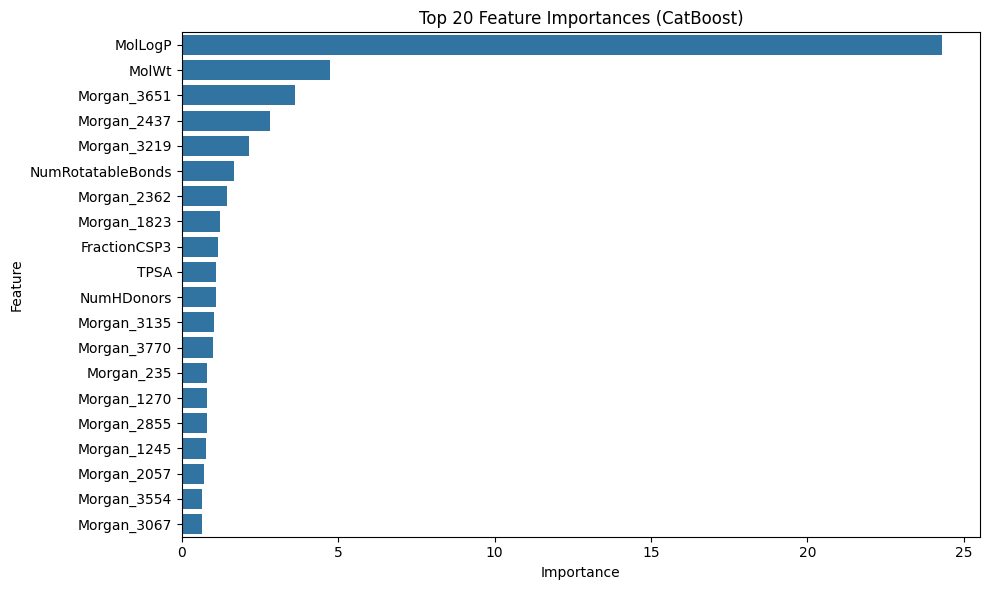

In [15]:
# 모델 학습 후
importances = model.get_feature_importance()
X, feature_names = extract_features_with_names(train_df)

# 데이터프레임으로 정리
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df.head(20))
plt.title('Top 20 Feature Importances (CatBoost)')
plt.tight_layout()
plt.show()
